<a href="https://colab.research.google.com/github/jplulu/Frequentist-ML/blob/master/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import math

# Prostate Data Analysis

In [251]:
# -----------------Using prostate data from the book

# Read data
df = pd.read_csv('https://github.com/jplulu/Frequentist-ML/raw/master/datasets/prostate.csv', sep='\t', index_col=0).drop(['train'],axis=1)

In [252]:
# ----------------- Preprocess data

# Shuffle data
np.random.seed(45)
df_shuffle = df.sample(frac=1)
df_x = df_shuffle.drop(['lpsa'], axis=1)
df_y = df_shuffle['lpsa']

# Standardizing predictors to zero mean unit variance
df_x = (df_x - df_x.mean()) / df_x.std()

# Added ones column for intercept
ones_col = np.ones(len(df_x))
df_x.insert(0, "intercept", ones_col)

# Separate training, validation, and testing data
x_train, x_val, x_test = np.split(df_x, [int(0.8*len(df_x)), int(0.9*len(df_x))])
y_train, y_val, y_test = np.split(df_y, [int(0.8*len(df_y)), int(0.9*len(df_y))])

# Part A - Linear Regression

In [253]:
# -----------------Linear Regression, No regularization

# Train the model and compute beta
def compute_beta_noreg(x_train, y_train):
  # Equation (3.6)
  x_train_inv = np.linalg.inv(np.dot(x_train.transpose(), x_train))
  beta_noreg = np.dot(np.dot(x_train_inv, x_train.transpose()), y_train)
  return beta_noreg

# Compute coefficients
beta_noreg = compute_beta_noreg(x_train, y_train)

# Compute baseline MSE
mse_baseline = np.mean((y_test - y_train.mean())**2)
print("Baseline MSE: {}".format(mse_baseline))

# Compute MSE on the test dataset
mse_noreg = np.mean((y_test - np.dot(x_test, beta_noreg))**2)
print("MSE on the test dataset: {}".format(mse_noreg))

Baseline MSE: 1.1536594885530849
MSE on the test dataset: 0.5925577682336172


The MSE on the test set using linear regression is much lower than the baseline MSE.

In [254]:
# -----------------Recreate Tables 3.1 and 3.2

# Compute and display correlation matrix
corr_matrix = df_x.drop(['intercept'], axis=1).corr()
display(corr_matrix)

# Compute and display linear model fit table
x_inv_diag = np.diagonal(np.linalg.inv(np.dot(x_train.transpose(), x_train)))
# Equation (3.12)
std_err = np.dot(beta_noreg.std(), np.sqrt(x_inv_diag))
z_score = beta_noreg / std_err
zipped_list =  list(zip(list(x_train.columns), beta_noreg, std_err, z_score))
model_fit_table = pd.DataFrame(zipped_list, columns = ['Term' , 'Coefficient', 'Std. Error', 'Z Score'])
display(model_fit_table)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.280521,0.225000,0.027350,0.538845,0.675310,0.432417,0.433652
lweight,0.280521,1.000000,0.347969,0.442264,0.155385,0.164537,0.056882,0.107354
age,0.225000,0.347969,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112
lbph,0.027350,0.442264,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460
svi,0.538845,0.155385,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648
lcp,0.675310,0.164537,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528
gleason,0.432417,0.056882,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905
pgg45,0.433652,0.107354,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000


,Term,Coefficient,Std. Error,Z Score
0,intercept,2.521918,0.089372,28.218341
1,lcavol,0.719999,0.134201,5.365088
2,lweight,0.179474,0.113430,1.582249
3,age,-0.162338,0.103746,-1.564761
4,lbph,0.230102,0.109494,2.101493
5,svi,0.366567,0.130739,2.803813
6,lcp,-0.154206,0.157148,-0.981280
7,gleason,0.111761,0.136274,0.820119
8,pgg45,0.111712,0.141981,0.786805


# Part B - Ridge Regression

In [255]:
# -----------------Ridge Regression

def compute_beta_ridge(lam_vec, x_train, y_train, x_val, y_val):
  # Initialize variables
  min_mse = float('inf')
  best_lam = None
  beta_ridge = []

  # Initialize coefficient array for plotting
  ridge_graph_vec = np.zeros((len(lam_vec), x_train.shape[1]))

  # Determine the optimal lambda
  for index, lam in enumerate(lam_vec):
    # Equation (3.44)
    ridge_inv = np.linalg.inv(np.dot(np.transpose(x_train),x_train) + lam*np.eye(x_train.shape[1]))
    beta = np.dot(np.dot(ridge_inv, np.transpose(x_train)), y_train)
    # Save the coefficients for plotting
    ridge_graph_vec[index,:] = beta
    # Calulate MSE for current lambda
    mse_ridge = np.mean((y_val - np.dot(x_val, beta))**2)
    # If MSE less than min MSE: update min MSE, best lambda, and coefficients
    if mse_ridge < min_mse:
      min_mse = mse_ridge
      best_lam = lam
      beta_ridge = beta

  return beta_ridge, ridge_graph_vec, best_lam

# Initialize lambda array
lam_vec = np.linspace(0,10,num=1000)

# Compute optimal coefficients
beta_ridge, ridge_graph_vec, best_lam = compute_beta_ridge(lam_vec, x_train, y_train, x_val, y_val)

print("Baseline MSE: {}".format(mse_baseline))

# Calculate MSE with the test data
mse_ridge = np.mean((y_test - np.dot(x_test, beta_ridge))**2)
print("MSE using ridge regression on the test dataset: {}".format(mse_ridge))

Baseline MSE: 1.1536594885530849
MSE using ridge regression on the test dataset: 0.46573288225858456


Using ridge regression, the MSE is further reduced from linear regression, similar to the book.

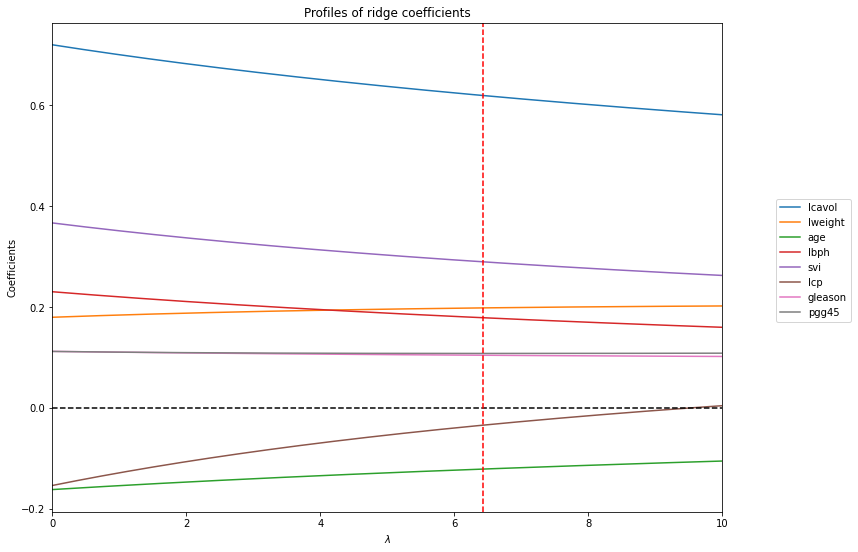

In [256]:
# -----------------Recreate Figure 3.8

fig = plt.figure(figsize=(12,9))
for index in range(1, x_train.shape[1]):
  plt.plot(lam_vec, ridge_graph_vec[:,index])
plt.plot((0,10), (0,0), 'k--')
plt.axvline(best_lam, 0, 3, linestyle="--", color='red')
plt.legend(x_train.columns[1:], loc='upper right', bbox_to_anchor=(1.2, 0.65))
plt.title('Profiles of ridge coefficients')
plt.ylabel('Coefficients')
plt.xlabel('$\lambda$')
plt.xlim([0,10])
plt.show()

# Part C - Lasso Regression

In [257]:
# -----------------Lasso Regression

def compute_beta_lasso(lam_vec, x_train, y_train, x_val, y_val):
  # Initialize variables
  min_mse = float('inf')
  best_lam = None
  beta_lasso = []

  # Initialize coefficient array for plotting
  lasso_graph_vec = np.zeros((len(lam_vec), x_train.shape[1]))

  x_train_lasso = x_train.drop(['intercept'], axis=1)
  beta_zero = np.mean(y_train)

  # Determine the optimal lambda
  for index, lam in enumerate(lam_vec):
    clf = Lasso(alpha=lam)
    clf.fit(x_train_lasso, y_train)
    beta = np.concatenate(([beta_zero], clf.coef_), axis=0)
    # Save the coefficients for plotting
    lasso_graph_vec[index,:] = beta
    # Calulate MSE for current lambda
    mse_lasso = np.mean((y_val - np.dot(x_val, beta))**2)
    # If MSE less than min MSE: update min MSE, best lambda, and coefficients
    if mse_lasso < min_mse:
      min_mse = mse_lasso
      best_lam = lam
      beta_lasso = beta
    
  return beta_lasso, lasso_graph_vec, best_lam

# Initialize lambda array
lam_vec = np.linspace(1e-10,0.5,num=1000)

# Compute optimal coefficients
beta_lasso, lasso_graph_vec, best_lam = compute_beta_lasso(lam_vec, x_train, y_train, x_val, y_val)

print("Baseline MSE: {}".format(mse_baseline))

# Calculate MSE with the test data
mse_lasso = np.mean((y_test - np.dot(x_test, beta_lasso))**2)
print("MSE using lasso regression on the test dataset: {}".format(mse_lasso))

Baseline MSE: 1.1536594885530849
MSE using lasso regression on the test dataset: 0.49609801343035365


Using lasso regression, the MSE is lower than linear regression but slightly higher than ridge regression

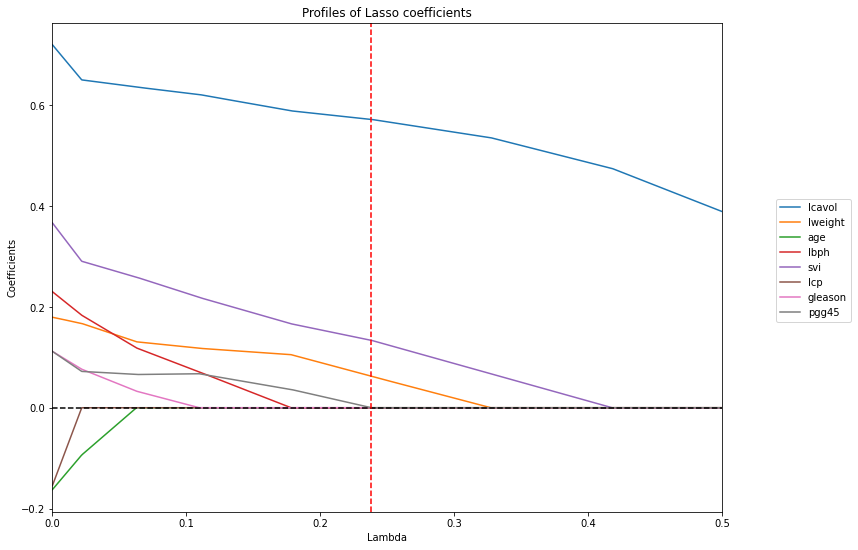

In [258]:
# -----------------Recreate Figure 3.10

fig = plt.figure(figsize=(12,9))
for index in range(1, x_train.shape[1]):
  plt.plot(lam_vec, lasso_graph_vec[:,index])
plt.plot((0,5), (0,0), 'k--')
plt.axvline(best_lam, 0, 3, linestyle="--", color='red')
plt.legend(x_train.columns[1:], loc='upper right', bbox_to_anchor=(1.2, 0.65))
plt.title('Profiles of Lasso coefficients')
plt.ylabel('Coefficients')
plt.xlabel('Lambda')
plt.xlim([0,0.5])
plt.show()

# Heart Disease Data Analysis

https://www.kaggle.com/ronitf/heart-disease-uci

This dataset predicts heart disease in a person based on a number of features

Features:

*   age
*   sex
*   cp - chest pain type
*   trestbps - resting blood pressure (in mm Hg on admission to the hospital)
*   chol - serum cholestoral in mg/dl
*   fbs - fasting blood sugar
*   restecg - resting electrocardiographic results
*   thalach - maximum heart rate achieved
*   exang - exercise induced angina
*   oldpeak - ST depression induced by exercise relative to rest
*   slope - the slope of the peak exercise ST segment
*   ca - number of major vessels colored by flourosopy
*   thal




In [259]:
# -----------------Load custom data

df = pd.read_csv('https://github.com/jplulu/Frequentist-ML/raw/master/datasets/heart.csv')
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [260]:
# ----------------- Preprocess data

# Shuffle data
np.random.seed(31431)
df_shuffle = df.sample(frac=1)
df_x = df_shuffle.drop(['target'], axis=1)
df_y = df_shuffle['target']

# Standardizing predictors to zero mean unit variance
df_x = (df_x - df_x.mean()) / df_x.std()

# Added ones column for intercept
ones_col = np.ones(len(df_x))
df_x.insert(0, "intercept", ones_col)

# Separate training, validation, and testing data
x_train, x_val, x_test = np.split(df_x, [int(0.8*len(df_x)), int(0.9*len(df_x))])
y_train, y_val, y_test = np.split(df_y, [int(0.8*len(df_y)), int(0.9*len(df_y))])

# Part A - Linear Regression

In [261]:
# -----------------Linear Regression, No regularization

beta_noreg = compute_beta_noreg(x_train, y_train)

# Compute MSE on the training dataset
mse_noreg = np.mean((y_train - np.dot(x_train, beta_noreg))**2)
print("MSE on the train dataset: {}".format(mse_noreg))

# Compute MSE on the test dataset
mse_noreg = np.mean((y_test - np.dot(x_test, beta_noreg))**2)
print("MSE on the test dataset: {}".format(mse_noreg))

# Compute baseline MSE
mse_baseline = np.mean((y_test - y_train.mean())**2)
print("Baseline MSE: {}".format(mse_baseline))

MSE on the train dataset: 0.11246522394076901
MSE on the test dataset: 0.16045484367717538
Baseline MSE: 0.2707972088985638


The mean squared error on the training dataset is 0.1125 and the mean squared error on the test dataset is 0.1604 when linear regression without regularization is used. It makes sense that the error will increase slightly on the testing dataset because the parameters are chosen only based on the training data. The MSEs are lower than the baseline MSE.

In [262]:
# -----------------Recreate Tables 3.1 and 3.2

# Compute and display correlation matrix
corr_matrix = df_x.drop(['intercept'], axis=1).corr()
display(corr_matrix)

# Compute and display linear model fit table
x_inv_diag = np.diagonal(np.linalg.inv(np.dot(x_train.transpose(), x_train)))
# Equation (3.12)
std_err = np.dot(beta_noreg.std(), np.sqrt(x_inv_diag))
z_score = beta_noreg / std_err
zipped_list =  list(zip(list(x_train.columns), beta_noreg, std_err, z_score))
model_fit_table = pd.DataFrame(zipped_list, columns = ['Term' , 'Coefficient', 'Std. Error', 'Z Score'])
display(model_fit_table)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244


,Term,Coefficient,Std. Error,Z Score
0,intercept,0.551667,0.010367,53.212256
1,age,-0.013170,0.012155,-1.083462
2,sex,-0.100660,0.011092,-9.075360
3,cp,0.108588,0.011426,9.503215
4,trestbps,-0.022992,0.011167,-2.058970
5,chol,-0.036908,0.011013,-3.351429
6,fbs,-0.003378,0.010340,-0.326660
7,restecg,0.024761,0.011051,2.240658
8,thalach,0.083663,0.012796,6.538206
9,exang,-0.083319,0.012252,-6.800276


# Part B - Ridge Regression

In [263]:
# -----------------Ridge Regression

# Initialize lambda array
lam_vec = np.linspace(0,20,num=1000)

# Compute optimal coefficients
beta_ridge, ridge_graph_vec, best_lam = compute_beta_ridge(lam_vec, x_train, y_train, x_val, y_val)

# Compute MSE on the training dataset
mse_ridge = np.mean((y_train - np.dot(x_train, beta_ridge))**2)
print("MSE using ridge regression on the train dataset: {}".format(mse_ridge))

# Calculate MSE with the test data
mse_ridge = np.mean((y_test - np.dot(x_test, beta_ridge))**2)
print("MSE using ridge regression on the test dataset: {}".format(mse_ridge))

print("Baseline MSE: {}".format(mse_baseline))

MSE using ridge regression on the train dataset: 0.11295434151517193
MSE using ridge regression on the test dataset: 0.15765954488748204
Baseline MSE: 0.2707972088985638


The mean squared error on the training dataset is 0.1129 and the mean squared error on the testing dataset is 0.1576 when ridge regression with optimal $\lambda = 9.630$ is used. The error on the training dataset is slightly higher than before because the smallest possible mean squared error for this set is found by plain linear regression. The error on the testing set is a slight improvement from linear regression without regularization. The MSEs are lower than the baseline MSE.

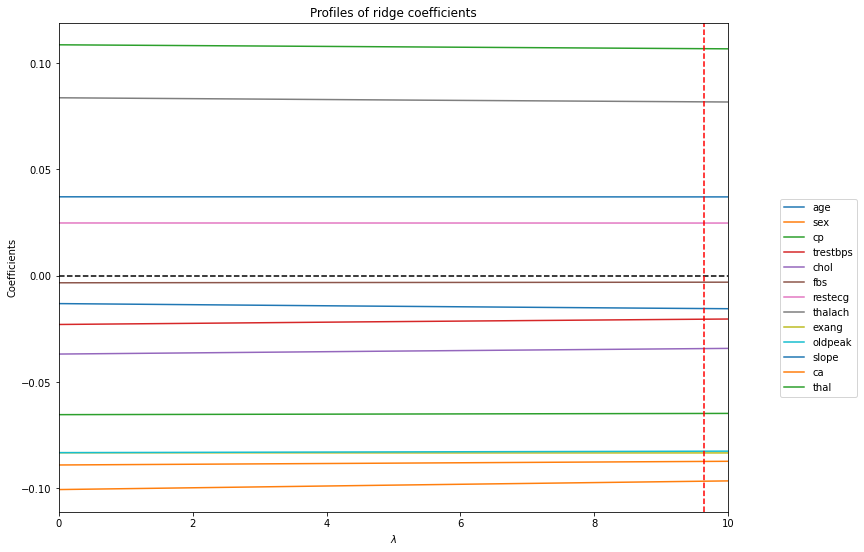

In [264]:
# -----------------Recreate Figure 3.8

fig = plt.figure(figsize=(12,9))
for index in range(1, x_train.shape[1]):
  plt.plot(lam_vec, ridge_graph_vec[:,index])
plt.plot((0,10), (0,0), 'k--')
plt.axvline(best_lam, 0, 3, linestyle="--", color='red')
plt.legend(x_train.columns[1:], loc='upper right', bbox_to_anchor=(1.2, 0.65))
plt.title('Profiles of ridge coefficients')
plt.ylabel('Coefficients')
plt.xlabel('$\lambda$')
plt.xlim([0,10])
plt.show()

# Part C - Lasso Regression

In [265]:
# -----------------Lasso Regression

# Initialize lambda array
lam_vec = np.linspace(1e-10,0.5,num=1000)

# Compute optimal coefficients
beta_lasso, lasso_graph_vec, best_lam = compute_beta_lasso(lam_vec, x_train, y_train, x_val, y_val)
print(best_lam)
# Compute MSE on the training dataset
mse_lasso = np.mean((y_train - np.dot(x_train, beta_lasso))**2)
print("Mean squared error on the train dataset: {}".format(mse_lasso))

# Calculate MSE with the test data
mse_lasso = np.mean((y_test - np.dot(x_test, beta_lasso))**2)
print("MSE using lasso regression on the test dataset: {}".format(mse_lasso))

print("Baseline MSE: {}\n".format(mse_baseline))

# Find included and excluded features
lasso_features = [i for i in x_train.columns[beta_lasso != 0]]
lasso_excluded_features = list(set(x_train.columns.values)-set(lasso_features))
print("Features included by lasso method:", lasso_features)
print("Features excluded by lasso method:", lasso_excluded_features)

0.02602602612082082
Mean squared error on the train dataset: 0.11650317811416
MSE using lasso regression on the test dataset: 0.15658411990543547
Baseline MSE: 0.2707972088985638

Features included by lasso method: ['intercept', 'age', 'sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Features excluded by lasso method: ['fbs']


The mean squared error on the training dataset is 0.1140 and the mean squared error on the testing dataset is 0.1770 when lasso regression with $\lambda = 0.0260$ is used. The error on the training dataset is slightly higher than both linear regression and ridge regression. While the error on the testing set is the lowest of all methods. The MSEs are lower than the baseline MSE.

The lasso regression excluded fasting blood sugar level > 120 mg/dl. It is not very surprising since although it may contribute to heart disease, there may not be a very direct and strong correlation between them. In additon, the magnitude of its z-score is only 0.326660, which is the lowest of all the predictors. This indicates that this feature does not have a big impact on the label.

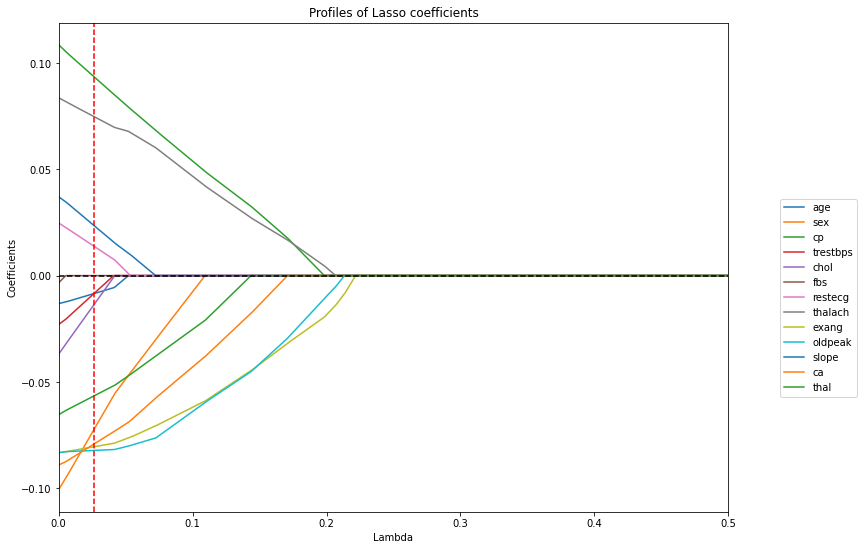

In [266]:
# -----------------Recreate Figure 3.10

fig = plt.figure(figsize=(12,9))
for index in range(1, x_train.shape[1]):
  plt.plot(lam_vec, lasso_graph_vec[:,index])
plt.plot((0,0.5), (0,0), 'k--')
plt.axvline(best_lam, 0, 3, linestyle="--", color='red')
plt.legend(x_train.columns[1:], loc='upper right', bbox_to_anchor=(1.2, 0.65))
plt.title('Profiles of Lasso coefficients')
plt.ylabel('Coefficients')
plt.xlabel('Lambda')
plt.xlim([0,0.5])
plt.show()

# Stretch Goal - Adding Interaction Terms

In [267]:
# Add interaction terms
df_x_mod = df_x.copy(True)
df_x_mod.insert(14, "Interaction1", df_x_mod['cp']**2)
df_x_mod.insert(15, "Interaction2", df_x_mod['fbs']**2)

# Separate training, validation, and testing data
x_train, x_val, x_test = np.split(df_x_mod, [int(0.8*len(df_x_mod)), int(0.9*len(df_x_mod))])
y_train, y_val, y_test = np.split(df_y, [int(0.8*len(df_y)), int(0.9*len(df_y))])

df_x_mod.describe()

,intercept,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Interaction1,Interaction2
count,303.0,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,303.000000,303.000000
mean,1.0,3.261051e-17,-2.081210e-16,1.520602e-16,-6.936146e-16,-8.610641e-17,-2.469605e-16,1.612205e-16,-5.496154e-16,2.301056e-16,-2.293728e-16,-1.311749e-16,-2.125179e-17,-1.788082e-16,0.996700,0.996700
std,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.896731,1.973539
min,1.0,-2.793003e+00,-1.465992e+00,-9.369647e-01,-2.145254e+00,-2.320322e+00,-4.169448e-01,-1.004171e+00,-3.433587e+00,-6.954800e-01,-8.953805e-01,-2.270822e+00,-7.132490e-01,-3.778573e+00,0.001023,0.173843
25%,1.0,-7.560295e-01,-1.465992e+00,-9.369647e-01,-6.627704e-01,-6.803688e-01,-4.169448e-01,-1.004171e+00,-7.049444e-01,-6.954800e-01,-8.953805e-01,-6.480412e-01,-7.132490e-01,-5.120748e-01,0.877903,0.173843
50%,1.0,6.977057e-02,6.798805e-01,3.197832e-02,-9.258463e-02,-1.208554e-01,-4.169448e-01,8.974776e-01,1.463921e-01,-6.954800e-01,-2.063639e-01,-6.480412e-01,-7.132490e-01,-5.120748e-01,0.877903,0.173843
75%,1.0,7.304107e-01,6.798805e-01,1.000921e+00,4.776012e-01,5.447726e-01,-4.169448e-01,8.974776e-01,7.139498e-01,1.433110e+00,4.826527e-01,9.747397e-01,2.646444e-01,1.121174e+00,1.001843,0.173843
max,1.0,2.492118e+00,6.798805e-01,1.969864e+00,3.898716e+00,6.130260e+00,2.390484e+00,2.799126e+00,2.285648e+00,1.433110e+00,4.444498e+00,9.747397e-01,3.198325e+00,1.121174e+00,3.880365,5.714411


In [268]:
# Compute coefficients for linear regression
beta_noreg = compute_beta_noreg(x_train, y_train)

# Compute MSE
mse_noreg_mod = np.mean((y_test - np.dot(x_test, beta_noreg))**2)

# Compute baseline MSE
mse_baseline = np.mean((y_test - y_train.mean())**2)

# Initialize lambda array
lam_vec = np.linspace(0,1,num=1000)

# Compute optimal coefficients for ridge
beta_ridge, ridge_graph_vec, best_lam = compute_beta_ridge(lam_vec, x_train, y_train, x_val, y_val)

# Calculate MSE
mse_ridge_mod = np.mean((y_test - np.dot(x_test, beta_ridge))**2)

# Initialize lambda array
lam_vec = np.linspace(1e-10,0.5,num=1000)

# Compute optimal coefficients for lasso
beta_lasso, lasso_graph_vec, best_lam = compute_beta_lasso(lam_vec, x_train, y_train, x_val, y_val)

# Calculate MSE
mse_lasso_mod = np.mean((y_test - np.dot(x_test, beta_lasso))**2)

table = [['Original', mse_baseline, mse_noreg, mse_ridge, mse_lasso], ['Mod', mse_baseline, mse_noreg_mod, mse_ridge_mod, mse_lasso_mod]]
table = pd.DataFrame(table, columns = ['Model', 'Baseline MSE' , 'MSE Linear', 'MSE Ridge', 'MSE Lasso'])
display(table)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016909501466901844, tolerance: 0.005930578512396694
  positive)


,Model,Baseline MSE,MSE Linear,MSE Ridge,MSE Lasso
0,Original,0.270797,0.160455,0.157660,0.156584
1,Mod,0.270797,0.154133,0.157387,0.155299


The data was modified by adding two interation terms to the original data. One term is the square of the 'cp' column, which had the highest impact on the label. The other term is the square of the 'fbs' column, which had the lowest impact on the label. It can be seen from the table above that this modification was able to decrease the MSE across the board for all three methods, although only slightly. This is likely due to the original data already being relatively linear since the original model had low MSEs to begin with. Nevertheless, modifying the dataset with nonlinear terms was still able to reduce the MSE. I have also tried other interation terms such as square root, logarithmic, or multiplying two features together with the current modification being the best result.